# Nested rejection sampling

This example demonstrates how to use nested rejection sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

Nested sampling is the craziest way to calculate an integral that you'll ever come across, which has found widespread application in physics. The idea is based upon repeatedly partitioning the prior density to a given area of parameter space based on likelihood thresholds. These repeated partitions form sort of Matryoshka dolls of spaces, where the later surfaces are "nested" within the earlier ones. The space between the Matryoshka volumes constitutes "shells", whose volume can itself be approximated. By summing the volumes of these shells, the marginal likelihood can be calculated. It's bonkers, but it works. It works especially well for multimodal distributions, where traditional methods of calculating the marginal likelihood fail. As a very useful bi-product of nested sampling, posterior samples can be produced by importance sampling.

[1] "Nested Sampling for General Bayesian Computation", John Skilling, Bayesian Analysis (2006) [https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944](https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944).

First create fake data.

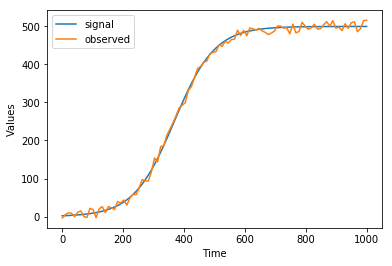

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.NestedRejectionSampler)

# Set number of iterations
sampler.set_iterations(3000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(300)

Run the sampler!

In [3]:
samples = sampler.run()
print('Done!')

Running Nested rejection sampler
Number of active points: 400
Total number of iterations: 3000
Total number of posterior samples: 300
Iter. Eval. Time m:s Delta_log(z) Acceptance rate
0     1       0:00.0 -inf          1             
0     2       0:00.0 -inf          1             
0     21      0:00.0 -inf          1             
0     41      0:00.0 -inf          1             
0     61      0:00.0 -inf          1             
0     81      0:00.0 -inf          1             
0     101     0:00.0 -inf          1             
0     121     0:00.0 -inf          1             
0     141     0:00.0 -inf          1             
0     161     0:00.0 -inf          1             
0     181     0:00.0 -inf          1             
0     201     0:00.0 -inf          1             
0     221     0:00.0 -inf          1             
0     241     0:00.0 -inf          1             
0     261     0:00.0 -inf          1             
0     281     0:00.0 -inf          1             
0     301     0:

2780  352438   0:38.4 -14.39155097  0.00789687477 
2800  370071   0:42.8 -14.02172634  0.00757430256 
2820  403182   0:52.8 -13.6535636   0.00700130592 
2840  419444   0:57.0 -13.56274993  0.00677733126 
2860  433167   1:00.5 -13.22855669  0.00660863698 
2880  450780   1:05.1 -12.90779864  0.00639460012 
2900  475464   1:11.2 -12.57087746  0.00610444066 
2920  497775   1:16.3 -12.24281505  0.00587082181 
2940  523789   1:22.0 -11.90509479  0.00561723689 
2960  553972   1:24.9 -11.587114    0.00534709125 
2980  584939   1:27.3 -11.29146672  0.00509803452 
3000  608174   1:29.2 -10.9867037   0.00493604531 
Done!


## Plot posterior samples versus true parameter values (dashed lines)

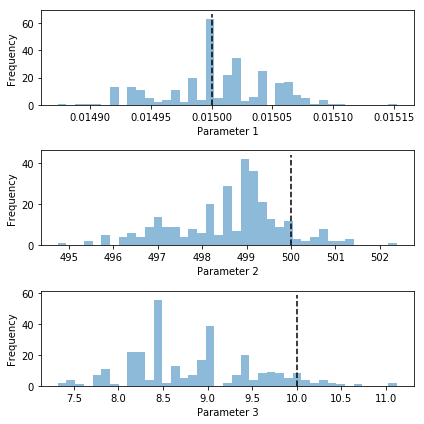

In [4]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

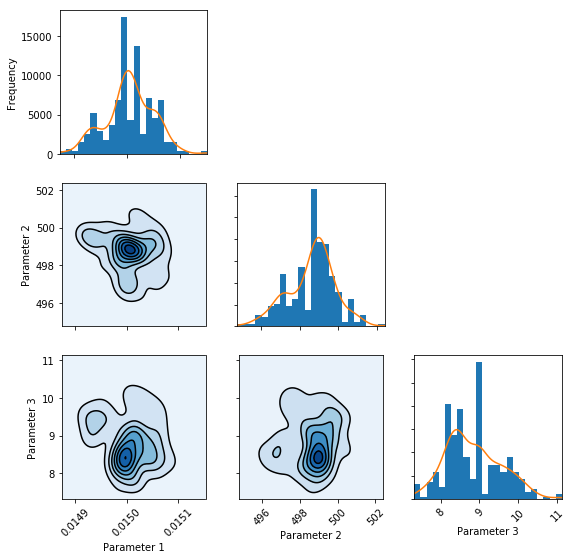

In [5]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

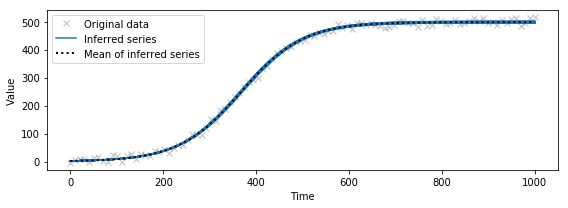

In [6]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate
Nested sampling calculates the denominator of Bayes' rule through applying the trapezium rule to the integral,

$$Z = \int_{0}^{1} \mathcal{L}(X) dX,$$

where $X$ is the prior probability mass.

In [7]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -368.1116589772709 ± 0.08064572183322265


With PINTS we can access the segments of the discretised integral, meaning we can plot the function being integrated.

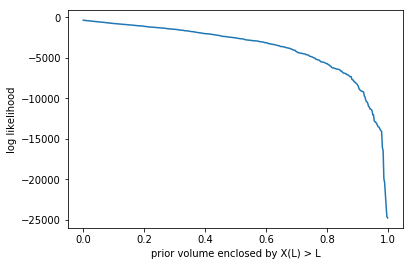

In [8]:
v_log_likelihood = sampler.log_likelihood_vector()
v_log_likelihood = v_log_likelihood[:-sampler._sampler.n_active_points()]
X = sampler.prior_space()
X = X[:-1]
plt.plot(X, v_log_likelihood)
plt.xlabel('prior volume enclosed by X(L) > L')
plt.ylabel('log likelihood')
plt.show()

## Examine active and inactive points at end of sampling run

At each step of the nested sampling algorithm, the point with the lowest likelihood is discarded (and inactivated) and a new active point is drawn from the prior, with the restriction of that its likelihood exceeds the discarded one. The likelihood of the inactived point essentially defines the height of a segment of the discretised integral for $Z$. Its width is approximately given by $w_i = X_{i-1}-X_{i+1}$, where $X_i = \text{exp}(-i / N)$ and $N$ is the number of active particles and $i$ is the iteration.

PINTS keeps track of active and inactive points at the end of the nested sampling run. The active points (orange) are concentrated in a region of high likelihood, whose likelihood always exceeds the discarded inactive points (blue).

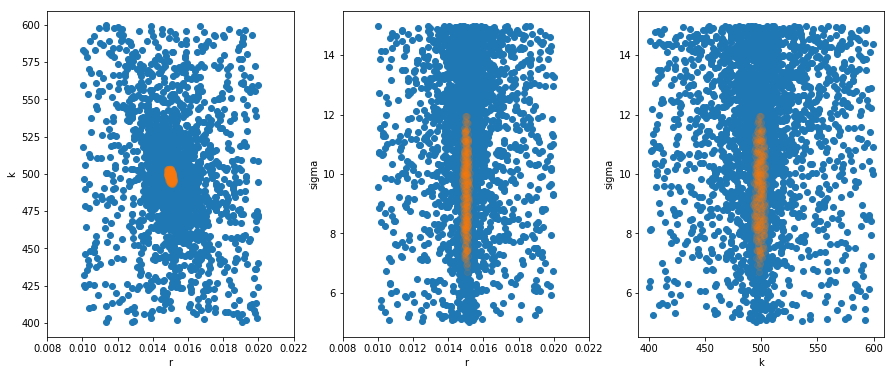

In [9]:
m_active = sampler.active_points()
m_inactive = sampler.inactive_points()

f, axarr = plt.subplots(1,3,figsize=(15,6))
axarr[0].scatter(m_inactive[:,0],m_inactive[:,1])
axarr[0].scatter(m_active[:,0],m_active[:,1],alpha=0.1)
axarr[0].set_xlim([0.008,0.022])
axarr[0].set_xlabel('r')
axarr[0].set_ylabel('k')
axarr[1].scatter(m_inactive[:,0],m_inactive[:,2])
axarr[1].scatter(m_active[:,0],m_active[:,2],alpha=0.1)
axarr[1].set_xlim([0.008,0.022])
axarr[1].set_xlabel('r')
axarr[1].set_ylabel('sigma')
axarr[2].scatter(m_inactive[:,1],m_inactive[:,2])
axarr[2].scatter(m_active[:,1],m_active[:,2],alpha=0.1)
axarr[2].set_xlabel('k')
axarr[2].set_ylabel('sigma')
plt.show()

## Sample some other posterior samples from recent run

In nested sampling, we can apply importance sampling to the inactivated points to generate posterior samples. In this case, the weight of each inactive point is given by $w_i \mathcal{L}_i$, where $\mathcal{L}_i$ is its likelihood. Since we use importance sampling, we can always generate an alternative set of posterior samples by re-applying this method.

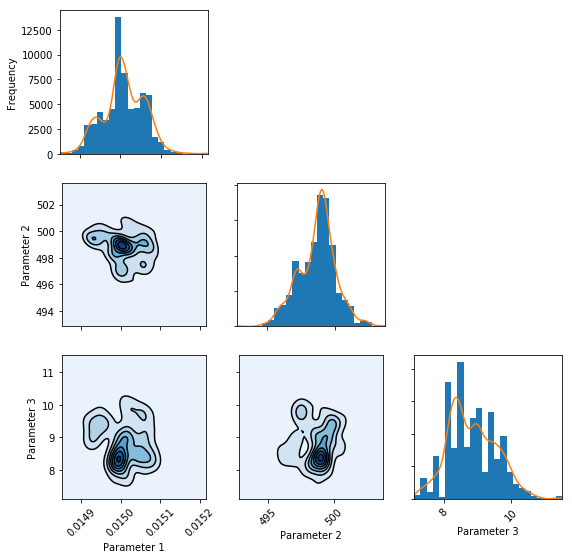

In [10]:
samples_new = sampler.sample_from_posterior(1000)

pints.plot.pairwise(samples_new, kde=True)

plt.show()